<a href="https://colab.research.google.com/github/djgnatzy/MakeAIWork2/blob/main/apple_disease_classification_w__augmentation_confusion_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
cd '/content/drive/MyDrive/data'

/content/drive/.shortcut-targets-by-id/1DQIzo_cjXQXSNKb7CeB7ipGp5aysmbbs/data


In [83]:
!gdown -- "1DQIzo_cjXQXSNKb7CeB7ipGp5aysmbbs"

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1DQIzo_cjXQXSNKb7CeB7ipGp5aysmbbs 



In [84]:
# directory='drive/My Drive/data/Train'

In [85]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
keras = tf.keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing

import random

## Download and explore the dataset

This convolutional neural network uses a dataset of about 850 photos of apples. The dataset contains four sub-directories, one per class:

```
data/
  Train/
    Blotch_Apple/
    Normal_Apple/
    Rot_Apple/
    Scab_Apple/
```

In [5]:
import pathlib
data_dir = '/content/drive/My Drive/data/train'   #'drive/My Drive/data/Train'

data_dir = pathlib.Path(data_dir) 

In [6]:
print(type(data_dir))

<class 'pathlib.PosixPath'>


In [89]:
# import os

# folder = data_dir #'data/Train/Blotch_Apple/'
# count = 1
# # count increase by 1 in each iteration
# # iterate all files from a directory
# for file_name in os.listdir(folder):
#     # Construct old file name
#     source = folder + file_name

#     # Adding the count to the new file name and extension
#     destination = folder + "blotch_" + str(count) + ".jpg"

#     # Renaming the file
#     os.rename(source, destination)
#     count += 1

# print('All files renamed')

# print('New names are:')
# # verify the result
# result = os.listdir(folder)
# print(result)

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [90]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

380


Here are some roses:

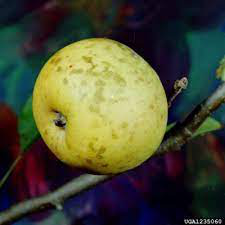

In [91]:
blotches = list(data_dir.glob('Blotch_Apple/*'))
PIL.Image.open(str(blotches[45]))

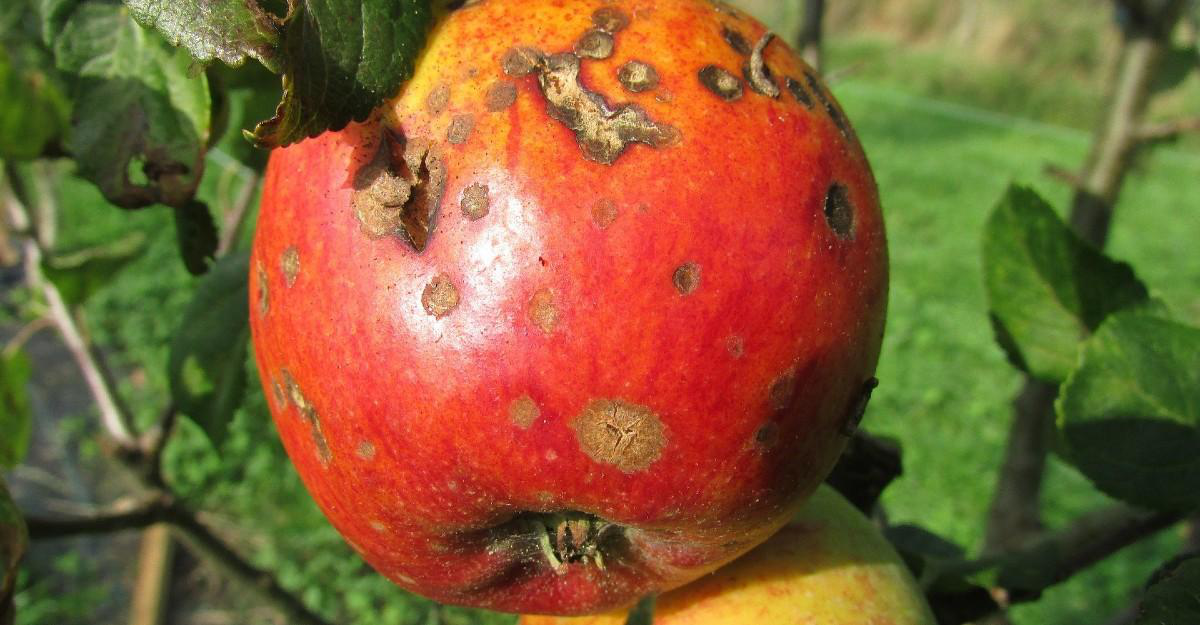

In [92]:
PIL.Image.open(str(blotches[1]))

And some tulips:

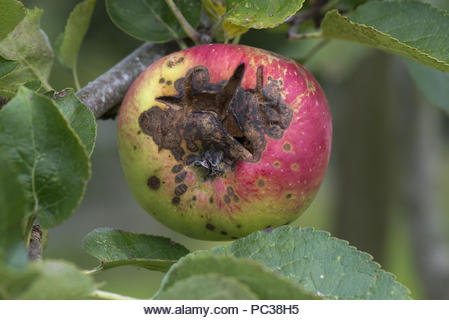

In [93]:
scabs = list(data_dir.glob('Scab_Apple/*'))
PIL.Image.open(str(scabs[0]))

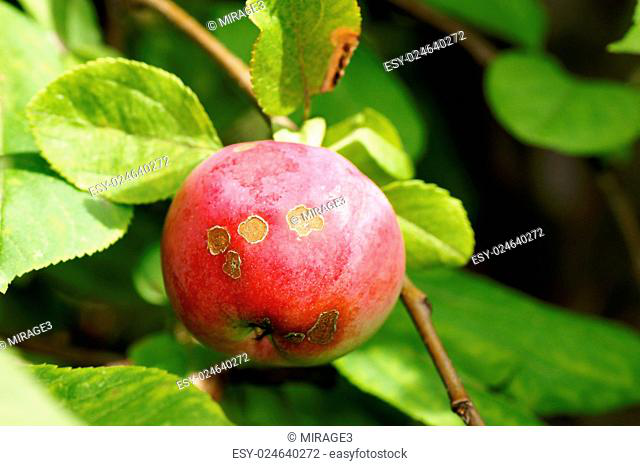

In [94]:
PIL.Image.open(str(scabs[50]))

### Create a dataset

Define some parameters for the loader:

In [95]:
batch_size = 32
img_height = 360
img_width = 360

In [96]:
data_dir = '/content/drive/MyDrive/data/train'

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [97]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 307 files for training.


In [98]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 76 files for validation.


In [99]:
class_names = train_ds.class_names
print(class_names)

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']


## Visualize the data

Here are the first nine images from the training dataset:

In [100]:
# import matplotlib.pyplot as plt
# # import random

# plt.figure(figsize=(15, 15))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [101]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 360, 3)
(32,)


# Importeer tevens de test data

In [102]:
test_dir = '/content/drive/My Drive/data/test'
test_dir = pathlib.Path(test_dir) 

image_count = len(list(test_dir.glob('*/*.jpg')))
print(image_count)

119
<class 'pathlib.PosixPath'>


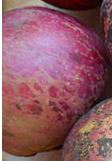

In [103]:
blotchez = list(test_dir.glob('Blotch_Apple/*'))
PIL.Image.open(str(blotchez[1]))

In [104]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 120 files belonging to 4 classes.


In [105]:
class_names = test_ds.class_names
print(class_names)

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']


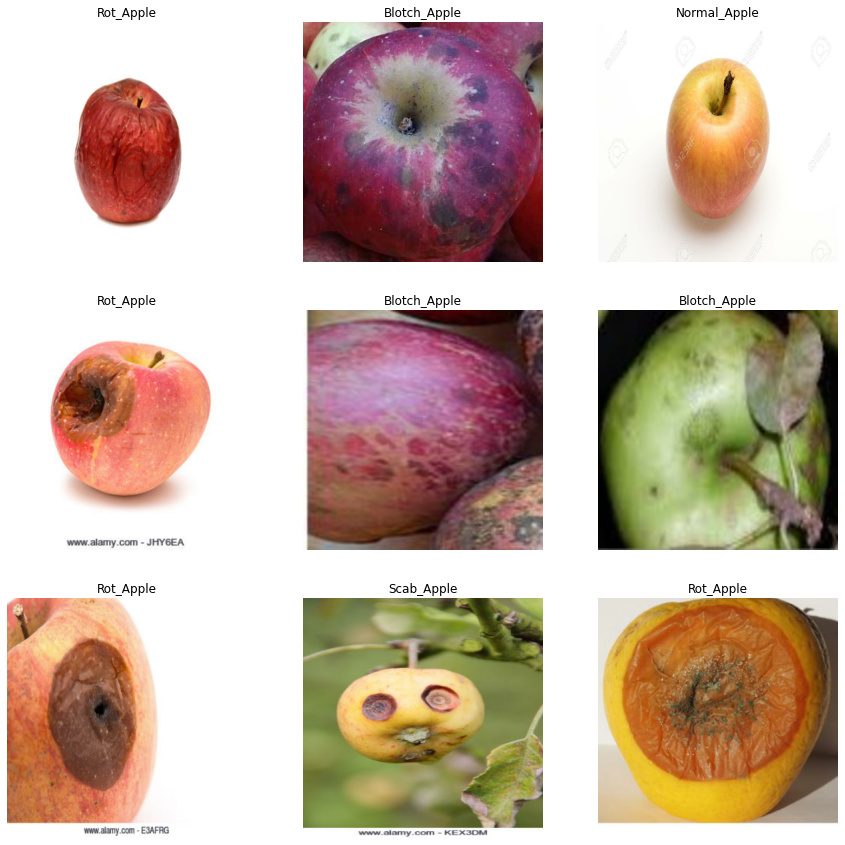

In [106]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [111]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 360, 3)
(32,)


## Standardize the data

In [113]:
normalization_layer = layers.Rescaling(1./255)

## Basic Keras model


In [117]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [118]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [119]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [120]:
# model.summary()

In [121]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  # callbacks=[callback]
)

Epoch 1/15
10/10 [==============================] - 44s 4s/step - loss: 5.0366 - accuracy: 0.2378 - val_loss: 1.2252 - val_accuracy: 0.5921
Epoch 2/15
10/10 [==============================] - 44s 4s/step - loss: 0.9669 - accuracy: 0.6612 - val_loss: 1.1142 - val_accuracy: 0.5789
Epoch 3/15
10/10 [==============================] - 58s 6s/step - loss: 0.7592 - accuracy: 0.6710 - val_loss: 0.9946 - val_accuracy: 0.6053
Epoch 4/15
10/10 [==============================] - 64s 6s/step - loss: 0.5208 - accuracy: 0.8567 - val_loss: 0.8758 - val_accuracy: 0.7237
Epoch 5/15
10/10 [==============================] - 53s 5s/step - loss: 0.3438 - accuracy: 0.8827 - val_loss: 1.0030 - val_accuracy: 0.6974
Epoch 6/15
10/10 [==============================] - 51s 4s/step - loss: 0.2583 - accuracy: 0.9218 - val_loss: 0.8752 - val_accuracy: 0.7895
Epoch 7/15
10/10 [==============================] - 48s 5s/step - loss: 0.2258 - accuracy: 0.9316 - val_loss: 1.0484 - val_accuracy: 0.6711
Epoch 8/15
10/10 [==

In [122]:
print(len(history.history['loss']))

15


## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

In [2]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
# plt.savefig('saved_models/model_plots_xx.png') # om op te slaan
plt.show()

NameError: ignored

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

In [124]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    # layers.RandomZoom(0.2)
  ]
)

# print(type(data_augmentation))

Visualize a few augmented examples by applying data augmentation to the same image several times:

In [3]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images, training=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

    # for i in range(16):
    #     plt.subplot(4, 4, i+1)
    #     plt.xticks([])
    #     plt.yticks([])
    #     plt.grid(False)
    #     randomImage = random.randint(1, 848)
    #     plt.imshow(imageObjects[randomImage])
    #     plt.xlabel(labelNames[labelNumbers[randomImage]]) 

NameError: ignored

In [126]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(images, 0), tf.float32)

You will add data augmentation to your model before training in the next step.

## Batch Normalization

In [127]:
tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=False,
    beta_initializer='zeros',
    gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
)

# minus **kwargs

In [128]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,  
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

## Compile and train the model

In [129]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [130]:
# model.summary()

In [131]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
10/10 [==============================] - 51s 5s/step - loss: 5.0628 - accuracy: 0.3062 - val_loss: 1.4835 - val_accuracy: 0.2105
Epoch 2/15
10/10 [==============================] - 48s 5s/step - loss: 1.2980 - accuracy: 0.3746 - val_loss: 1.2452 - val_accuracy: 0.5263
Epoch 3/15
10/10 [==============================] - 48s 5s/step - loss: 1.1051 - accuracy: 0.5570 - val_loss: 1.2043 - val_accuracy: 0.4474
Epoch 4/15
10/10 [==============================] - 47s 5s/step - loss: 0.9773 - accuracy: 0.6091 - val_loss: 1.1250 - val_accuracy: 0.5526
Epoch 5/15
10/10 [==============================] - 51s 5s/step - loss: 0.9013 - accuracy: 0.6384 - val_loss: 1.1562 - val_accuracy: 0.5658
Epoch 6/15
10/10 [==============================] - 48s 5s/step - loss: 0.8754 - accuracy: 0.6450 - val_loss: 1.1718 - val_accuracy: 0.5526
Epoch 7/15
10/10 [==============================] - 45s 4s/step - loss: 0.8173 - accuracy: 0.6808 - val_loss: 1.1045 - val_accuracy: 0.5395
Epoch 8/15
10/10 [==

In [ ]:
print(len(history.history['loss']))

In [132]:
model.save("models_saved/model_adc.h5", overwrite=True, include_optimizer=True)

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

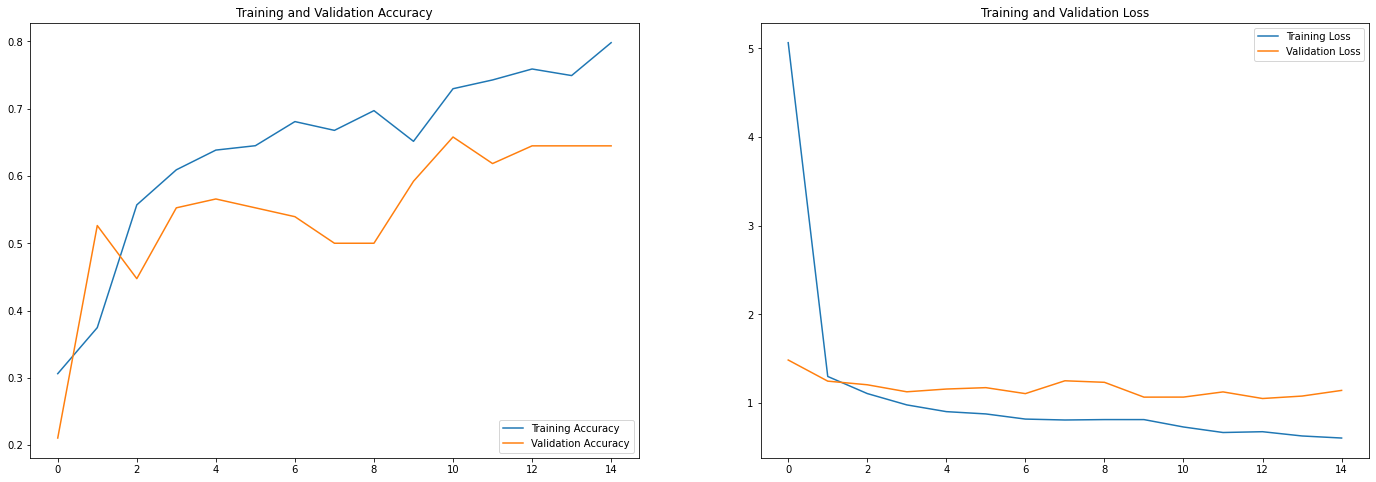

In [133]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [134]:
sunflower_url = "https://i.pinimg.com/originals/c3/d1/15/c3d115000eb05abf0c895122cca09d8b.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 158ms/step
This image most likely belongs to Blotch_Apple with a 86.88 percent confidence.


In [135]:
model.predict(test_ds)

4/4 [==============================] - 5s 978ms/step


array([[ 1.36561811e+00, -4.14573029e-02, -4.70430404e-02,
         2.80561781e+00],
       [ 1.74423611e+00, -1.78614163e+00,  1.18325639e+00,
         2.36678869e-01],
       [-6.59439504e-01,  6.70798063e+00, -1.38889527e+00,
         1.76236877e+01],
       [ 3.20867586e+00, -1.95915639e+00, -9.87637788e-02,
         6.56183660e-01],
       [ 2.43627191e+00, -6.19840562e-01,  5.17021567e-02,
         1.14121425e+00],
       [ 1.13173413e+00,  1.41359365e+00, -5.46481490e-01,
         7.65483189e+00],
       [ 2.84809661e+00, -8.32386255e-01,  8.48991722e-02,
         7.02370942e-01],
       [ 1.79609489e+00, -1.81254536e-01, -1.70965219e+00,
         7.24929857e+00],
       [ 3.06665421e+00, -4.85281110e-01, -2.92388767e-01,
         9.33513939e-01],
       [ 4.76030302e+00, -5.70014775e-01, -1.84050221e-02,
         2.74072409e+00],
       [ 1.75835311e+00, -2.76044130e-01,  4.31147635e-01,
         1.20676160e+00],
       [ 6.98984742e-01,  4.14415312e+00,  1.39459923e-01,
      

In [1]:
predictionBatch = model.predict(test_ds)
predictionEnhanced = tf.argmax(predictionBatch, axis=-1)
actualCategories = tf.concat([y for x, y in test_ds], axis=0)

# argmax van np. omgezet naar tf.
# actualCategories / tf.concat toegevoegd


NameError: ignored

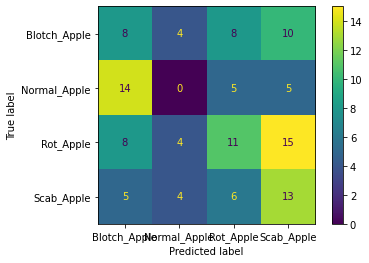

In [140]:
confusionMatrix = metrics.confusion_matrix(actualCategories, predictionEnhanced)

cmDisplay = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, displayLabels = ["Blotch_Apple", "Normal_Apple", "Rot_Apple", "Scab_Apple"])

cmDisplay.plot()

plt.show()